# Colab E4 — TensorFlow High-Level API (Sequential + fit) — 3-hidden-layer DNN for Non-Linear Regression

**Key requirements satisfied (E4):**
- Synthetic **3-variable** non-linear regression dataset (x1, x2, x3 → y)
- **Deep network with 3 hidden layers**
- Uses **TensorFlow high-level API** via `tf.keras.Sequential`
- Uses `model.compile()` + `model.fit()`
- Shows **loss vs epochs** (history) and **final predicted vs true** output plot
- Includes “4D” visualization: PCA (3D X → 2D) then plot (PC1, PC2, y) with color = x3

> E3 used the **Functional API** (graph style).  
> E4 uses **Sequential** (stacked layers) to demonstrate another high-level style.


In [1]:
# =========================
# Cell 1 — Setup
# =========================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

np.random.seed(7)
tf.random.set_seed(7)

print("TF version:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))


TF version: 2.19.0
GPU available: False


In [2]:
# =========================
# Cell 2 — Synthetic data (3 variables) + preprocessing
# =========================
N = 2000
X = np.random.uniform(-2.0, 2.0, size=(N, 3)).astype(np.float32)
x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]

noise = 0.10 * np.random.randn(N).astype(np.float32)
y = (
    np.sin(x1)
    + 0.5 * np.cos(x2 * x3)
    + 0.30 * (x2 ** 2)
    - 0.20 * (x3 ** 3)
    + 0.25 * np.sin(x1 * x2)
    + noise
).astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardize (train stats only)
X_mu, X_std = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True) + 1e-8
y_mu, y_std = y_train.mean(axis=0, keepdims=True), y_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - X_mu) / X_std
X_test_n  = (X_test  - X_mu) / X_std
y_train_n = (y_train - y_mu) / y_std
y_test_n  = (y_test  - y_mu) / y_std

print("Shapes:", X_train_n.shape, y_train_n.shape, X_test_n.shape, y_test_n.shape)


Shapes: (1600, 3) (1600, 1) (400, 3) (400, 1)


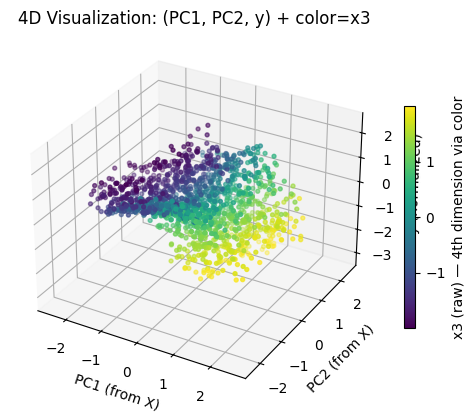

In [3]:
# =========================
# Cell 3 — 4D visualization (PCA for X, color = x3)
# =========================
pca = PCA(n_components=2, random_state=7)
X2 = pca.fit_transform(X_train_n)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X2[:, 0], X2[:, 1], y_train_n[:, 0], c=X_train[:, 2], s=8)

ax.set_xlabel("PC1 (from X)")
ax.set_ylabel("PC2 (from X)")
ax.set_zlabel("y (normalized)")
fig.colorbar(sc, ax=ax, shrink=0.6, label="x3 (raw) — 4th dimension via color")
plt.title("4D Visualization: (PC1, PC2, y) + color=x3")
plt.show()


In [4]:
# =========================
# Cell 4 — High-level Sequential model (3 hidden layers)
# =========================
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(3,), name="x"),
        tf.keras.layers.Dense(32, activation="tanh", name="dense1"),
        tf.keras.layers.Dense(32, activation="relu", name="dense2"),
        tf.keras.layers.Dense(16, activation="tanh", name="dense3"),
        tf.keras.layers.Dense(1, name="y"),  # linear output
    ],
    name="deep_regressor_sequential",
)

model.summary()


Model: "deep_regressor_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense1 (Dense)                  │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y (Dense)                       │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729 (6.75 KB)

 Trainable params: 1,729 (6.75 KB)

 Non-trainable params: 0 (0.00 B)

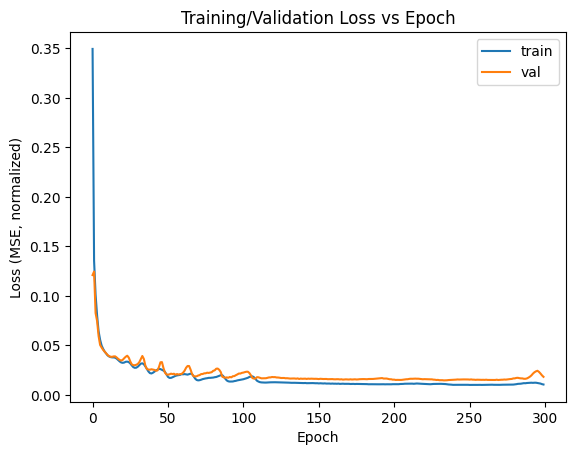

In [5]:
# =========================
# Cell 5 — Compile + Fit (high-level)
# =========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mse",
)

history = model.fit(
    X_train_n, y_train_n,
    validation_split=0.2,
    epochs=300,
    batch_size=128,
    verbose=0
)

plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE, normalized)")
plt.title("Training/Validation Loss vs Epoch")
plt.legend()
plt.show()


Test MSE (normalized): 0.018177
Test MSE (original scale): 0.019589


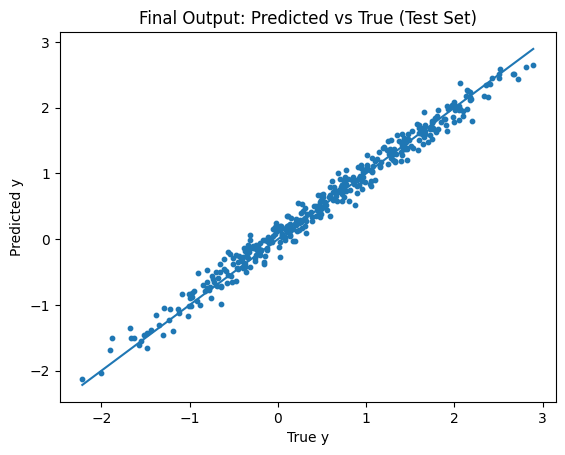

Sample 0: true= 0.0281 | pred=-0.0464
Sample 1: true= 1.2483 | pred= 1.4881
Sample 2: true=-0.7661 | pred=-0.7288
Sample 3: true= 1.8116 | pred= 1.6811
Sample 4: true= 1.6677 | pred= 1.7336


In [6]:
# =========================
# Cell 6 — Evaluation + final output
# =========================
yhat_n = model.predict(X_test_n, verbose=0)
test_mse_n = float(np.mean((yhat_n - y_test_n) ** 2))

# Unnormalize
yhat = (yhat_n * y_std + y_mu).reshape(-1, 1)
ytrue = y_test
test_mse = float(np.mean((yhat - ytrue) ** 2))

print(f"Test MSE (normalized): {test_mse_n:.6f}")
print(f"Test MSE (original scale): {test_mse:.6f}")

plt.figure()
plt.scatter(ytrue, yhat, s=10)
mn, mx = float(ytrue.min()), float(ytrue.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Final Output: Predicted vs True (Test Set)")
plt.show()

for i in range(5):
    print(f"Sample {i}: true={ytrue[i,0]: .4f} | pred={yhat[i,0]: .4f}")
